In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt. Use Bayesian exploration to explore the input space.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: bayesian_exploration
  options:  
      n_initial_samples: 5
      n_steps: 25
      verbose: True
      generator_options:                     ## options for bayesian exploration acquisition function
          batch_size: 1                      ## batch size for parallelized optimization
          #sigma: [[0.01, 0.0], [0.0,0.01]]   ## proximal biasing term
          use_gpu: False

  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

if SMOKE_TEST:
    config['algorithm']['options']['n_steps'] = 3
    config['algorithm']['options']['generator_options']['num_restarts'] = 2
    config['algorithm']['options']['generator_options']['raw_samples'] = 2

In [4]:
X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3+104.g5c5c916.dirty
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true, algorithm: cnsga}
algorithm:
  name: bayesian_exploration
  function: xopt.bayesian.algorithms.bayesian_exploration
  options:
    n_initial_samples: 5
    n_steps: 25
    verbose: true
    generator_options: {batch_size: 1, use_gpu: false, num_restarts: 2, raw_samples: 2}
    custom_model: null
    restart_file: null
    initial_x: null
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {}
  constants: {a: dummy_constant}

# Run BayesOpt

In [5]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [6]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-09-01T10:37:46-05:00
started running optimization with generator: <xopt.bayesian.generators.exploration.BayesianExplorationGenerator object at 0x0000029346636520>
submitting initial candidates at time 2021-09-01T10:37:46-05:00
starting optimization loop
Model creation time: 0.292 s
Candidate generation time: 0.09851 s
Candidate(s): tensor([[0.1022, 0.4816]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:37:47-05:00
Model creation time: 0.3145 s
Candidate generation time: 0.062 s
Candidate(s): tensor([[1.5026, 0.0000]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:37:47-05:00
Model creation time: 0.3 s
Candidate generation time: 0.076 s
Candidate(s): tensor([[0.4567, 1.1652]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:37:48-05:00
Model creation time: 0.383 s
Candidate generation time: 0.041 s
Candidate(s): tensor([[0.0000, 1.1605]], dtype=torch.float64)
submitting candidates at time 2021-09-01T10:37:48-0

# Plot
- plot input space samples -> yellow points satisfy constraints and purple points do not

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraints', 'corrected_constraints', 'constraint_status', 'feasibility', 'model'])


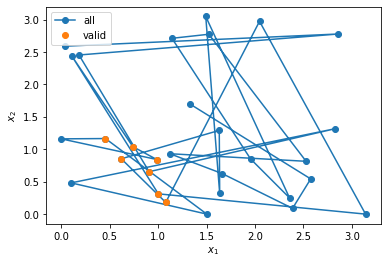

In [7]:


import matplotlib.pyplot as plt
%matplotlib inline

# plot exploration results and path - exploration should explore the feasible region of the TNK problem - See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf
fig, ax = plt.subplots()

results = X.results
print(results.keys())
variables = results['variables']
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o', label = 'all')
ax.plot(valid[:, 0], valid[:, 1], 'o', label = 'valid')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

plt.show()